In [ ]:
# Load all of the relevant packages


# For communicating with the Keysight SMU; Installation: pip install pyvisa
# Pyvisa requires that LabView VISA lirary is installed on your computer
import pyvisa

# For keeping track of time
import time

# For maniputalting data; Installation: pip install numpy
import numpy as np


# For maniputalting data; Installation: pip install pandas
import pandas as pd

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc, cm
import matplotlib.colors as colors

# SciPy for image processing; Installation: pip install scipy
from scipy import ndimage
from scipy import signal
import scipy.signal
import scipy.misc
from scipy.interpolate import griddata
from scipy.optimize import fmin_powell
import scipy.ndimage as snd
from scipy.fft import fft, ifft, fftfreq

# tkinter for interactive path generation
from tkinter import filedialog
from tkinter import *

# Needed for dealing with the frequency dependent data (not all columns are same length)
import pickle


In [1]:
# View the available resources

rm = pyvisa.ResourceManager()
rm.list_resources()

NameError: name 'pyvisa' is not defined

In [3]:
# Establish connection with the SMU

# Copy-paste the instrument address from above
inst = rm.open_resource('USB0::0x0957::0xCE18::MY51143745::INSTR')
print(inst.query("*IDN?"))

Keysight Technologies,B2902A,MY51143745,3.4.2011.5100



In [4]:
# Set the instrument timeout value in ms
# Must be longer that the longest measurement otherwise you will get an error

inst.timeout = 120*1e3 

In [ ]:
############################## Fitting functions ##############################

def sine(point, offset, amp, points_per_cycle):
    return offset+amp*np.sin(2*np.pi*(point%points_per_cycle)/points_per_cycle)

# Function for running fits of measured data to get ∆Ig and ∆Id
def sinFit1(t,amp,phi,I0):
    return I0 + amp*np.sin(2*np.pi*f_freq*t + phi)

# Function for running fits of measured data to get ∆Ig and ∆Id
def sinFit2(t,amp,phi,I0,freq):
    return I0 + amp*np.sin(2*np.pi*freq*t+(phi*(2*np.pi/360)))

def fitSineV3(t,I0,freq,amp,phase):
    return I0+amp*np.sin(2*np.pi*freq*t+((phase/360)*2*np.pi))

# Fit the measured Ig and Id to sine waves
# Good to check that fits actually match the data, sometimes scipy is bad at fitting sine waves
def fitSweeps(sweeps,freqs,points_per_cycle):

    # Initialize variables for the fit results (format amp, phi, I0, freq)
    Ig_fit = np.empty((len(freqs),4))
    Id_fit = np.empty((len(freqs),4))

    for i in range(0,len(sweeps)):

        # Initialize the starting guess and points
        p0 = [np.mean(sweeps[i][:,0]),freqs[i],0.5*(np.amax(sweeps[i][:,0])-np.amin(sweeps[i][:,0])),0]
        ppc = round(points_per_cycle[i])
        
        # Fit to sine(t,I0,freq,amp,phase)
        Ig_fit[i],_ = scipy.optimize.curve_fit(fitSineV3,sweeps[i][2*ppc:,1],sweeps[i][2*ppc:,0],p0=p0)

        # Initialize the starting guess and points
        p0 = [np.mean(sweeps[i][:,2]),freqs[i],0.5*(np.amax(sweeps[i][:,2])-np.amin(sweeps[i][:,2])),0]
        
        # Fit to sine(t,I0,freq,amp,phase)
        Id_fit[i],_ = scipy.optimize.curve_fit(fitSineV3,sweeps[i][2*ppc:,1],sweeps[i][2*ppc:,2],p0=p0)
        
    return Ig_fit,Id_fit

# Takes fits 
def fitSample(sweeps,freqs,point_per_cycle,Vg_amplitude,length,overlap,Vd):
    # Fit to sine(t,I0,freq,amp,phase)
    Ig_fit,Id_fit = fitSweeps(sweeps,freqs,points_per_cycle)
    
    # Calculate gm
    gm = np.divide(abs(Id_fit[:,2]),Vg_amplitude)
    # Fit capacitance
    
    Z = np.divide(Vg_amplitude,abs(Ig_fit[:,2]))
    b_fit = np.mean(np.log10(Z[:7])+np.log10(freqs[:7]))
    C = np.divide(np.power(10,-1*b_fit),2*np.pi)

    # Fit mobility
    
    m, b = np.polyfit(1/freqs,abs(Id_fit[:,2]/Ig_fit[:,2]), 1)
    
    mu = abs(m*(length*1e-4)*((length + 2*overlap)*1e-4)*2*np.pi/Vd)
    
    return gm,C,mu,Ig_fit,Id_fit

In [5]:
############################## Measurement functions ##############################

def runListSweep(parameters,ch1_list,ch2_list,wait=True):
    
    # parameters format (list of strings, units of seconds, amps, volts):
    # [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
    #  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
    #  (8) premeasurement voltage hold time]
    
    # Trigger TIM minimum of 2E-5
    # Acquisition time minimum of 8E-6
    
    # acq delay should be on the order of 5E-5 or greater
    # Measurement time + acq delay < trigger interval by at least 1E-5
    
    inst.write(":sour1:volt:lev:imm " + ch1_list.split(',')[0])
    inst.write(":sour2:volt:lev:imm " + ch2_list.split(',')[0])
    
    inst.write(":outp1 on")
    inst.write(":outp2 on")
    
    if wait == True:
        time.sleep(parameters[8])
    
    # Sets the measurement list of voltages for the gate (channel 1)
    inst.write(":sour1:func:mode volt")
    inst.write(":sour1:volt:mode list")
    inst.write(":sour1:list:volt " + ch1_list)
    # Sets the measurement list of voltages for the drain (channel 2)
    inst.write(":sour2:func:mode volt")
    inst.write(":sour2:volt:mode list")
    inst.write(":sour2:list:volt " + ch2_list)

    # Set range and interval for measurement
    inst.write(":sens1:func \"curr\"")
    inst.write(":sens1:curr:rang:auto off")
    inst.write(":sens1:curr:prot " + parameters[4])
    inst.write(":sens1:curr:rang " + parameters[4])
    inst.write(":sens2:func \"curr\"")
    
    inst.write(":sens2:curr:rang:auto off")
    inst.write(":sens2:curr:rang " + parameters[5])
    inst.write(":sens2:curr:prot " + parameters[5])
    
    # Source output ranging set to fixed mode
    inst.write(":sour1:volt:rang:auto off")
    inst.write(":sour1:volt:rang 2")
    inst.write(":sour2:volt:rang:auto off")
    inst.write(":sour2:volt:rang 2")
    # Mesurement wait time set to OFF
    inst.write(":sens1:wait off")
    inst.write(":sour1:wait off")
    inst.write(":sens2:wait off")
    inst.write(":sour2:wait off")
    
    # Set trigger source to the same mode
    inst.write(":trig1:sour tim")
    inst.write("trig1:tim " + parameters[1])
    inst.write("trig1:acq:coun " + parameters[0])
    inst.write(":trig1:acq:del " + parameters[2])
    inst.write("trig1:tran:coun " + parameters[6])
    inst.write(":trig1:tran:del 0")
    inst.write(":trig2:sour tim")
    inst.write("trig2:tim " + parameters[1])
    inst.write("trig2:acq:coun " + parameters[0])
    inst.write(":trig2:acq:del " + parameters[2])
    inst.write("trig2:tran:coun " + parameters[7])
    inst.write(":trig2:tran:del 0")

    # Measurement interval is set to the same value
    inst.write(":sens1:curr:aper " + parameters[3])
    inst.write(":sens2:curr:aper " + parameters[3])
    
    inst.write(":form:elem:sens curr,time")
    
    # Runs the measurement
    inst.write(":init (@1,2)")
    # Fetches the measurement data
    t1 = time.time()
    data_out = inst.query(":fetc:arr? (@1,2)")
    t2 = time.time()
    #print(t1-t2)
    # Convert string of data to numpy array
    data = np.asarray([float(i) for i in data_out.split(',')])
    # Return the measurement results
    
    #inst.write(":syst:beep 800,0.25")
    
    data = np.reshape(data, (int(parameters[0]),4))
    
    return data

def findIdRange(Vd,Vg,Ig_range):
    inst.write(":sour1:volt:lev:imm " + "{:.3E}".format(Vg))
    inst.write(":sour2:volt:lev:imm " + "{:.3E}".format(Vd))
    
    inst.write(":outp1 on")
    inst.write(":outp2 on")
    
    time.sleep(1)
    
    inst.write(":sens2:curr:aper:auto on")
    inst.write(":sens2:curr:prot 1")
    inst.write(":sens2:func \"curr\"")
    
    Id_range = 1e-7
    overload = True
    
    while overload == True:
        inst.write(":sens2:curr:rang " + '{:.0E}'.format(Id_range))
        data_out = float(inst.query(":meas:curr? (@2)"))
        if data_out == np.nan or abs(data_out) > 0.9*Id_range:
            Id_range = Id_range*10
        else:
            overload = False
    
    return Id_range

def generateSineSweep(cycles,points_per_cycle,amp,offset):
    sweep = ""
    for i in range(0,int(points_per_cycle*cycles)):
        sweep += "{:.3E}".format(round(sine(i, offset, amp, points_per_cycle),5)) + ","
    sweep += "{:.3E}".format(round(sine(i+1, offset, amp, points_per_cycle),5))
    return sweep

def generateLinSweep(points_per_sweep,v_start,v_end,reverse=False):
    sweep = ""
    for i in range(0,points_per_sweep):
        sweep += "{:.3E}".format(round(v_start + (i/points_per_sweep)*(v_end-v_start),5)) + ","
    sweep += "{:.3E}".format(round(v_start + ((i+1)/points_per_sweep)*(v_end-v_start),5))
    if reverse == True:
        sweep += ","
        for j in range(1,points_per_sweep):
            i = points_per_sweep - j 
            sweep += "{:.3E}".format(round(v_start + (i/points_per_sweep)*(v_end-v_start),5)) + ","
        sweep += "{:.3E}".format(round(v_start,5))
    return sweep

def generateFreqs(start_freq,end_freq,points_per_dec):
    decs = np.subtract(np.log10(end_freq),np.log10(start_freq))
    freqs = np.logspace(np.log10(start_freq),np.log10(end_freq),int(decs*points_per_dec))
    meas_time = "{:.1E}".format(1/(12*freqs[0]))
    for i in range(1, len(freqs)):
        meas_time += "," + "{:.1E}".format(1/(12*freqs[i]))
    meas_time = np.asarray([float(i) for i in meas_time.split(',')])
    freqs = 1/(12*meas_time)
    return freqs,meas_time

def generateFreqsV2(start_freq,end_freq,points_per_dec,max_meas_time=1e-3,min_meas_time=2e-5):
    decs = np.subtract(np.log10(end_freq),np.log10(start_freq))
    freqs = np.logspace(np.log10(start_freq),np.log10(end_freq),int(decs*points_per_dec))
    meas_time = np.empty((len(freqs),))
    points_per_cycle = np.empty((len(freqs),))
    meas_time[0] = max_meas_time
    for i in range(0,len(freqs)):
        if i > 0:
            meas_time[i] = meas_time[i-1]
        points_per_cycle[i] = np.round(1/(freqs[i]*meas_time[i]))
        while points_per_cycle[i] < 100 and meas_time[i] > min_meas_time:
            meas_time[i] = float("{:.1E}".format(meas_time[i]/2))
            points_per_cycle[i] = np.round(1/(freqs[i]*meas_time[i]))
        if meas_time[i] < min_meas_time:
            meas_time[i] = min_meas_time
            points_per_cycle[i] = np.round(1/(freqs[i]*meas_time[i]))
        freqs[i] = 1/(meas_time[i]*points_per_cycle[i])
    return freqs,points_per_cycle,meas_time

def generatePulse(Vi,Vf,width,t):
    v_list = ""
    points = round(width/t)
    for i in range(0,points):
        v_list += "{:.3E}".format(Vi) + ","
    for j in range(0,points):
        v_list += "{:.3E}".format(Vf) + ","
    for k in range(0,points-1):
        v_list += "{:.3E}".format(Vi) + ","
    v_list += "{:.3E}".format(Vi)
    return v_list

############################## Plotting functions ##############################

# Plots transconductance
def plotTransconductance(delta_Id,Vg_amp,freqs):
    gm = np.divide(delta_Id,Vg_amp)
    plt.loglog(freqs,gm)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("gm (S)")
    return gm
    
# Plots impedance graph
def plotImpedance(Ig_fit,Vg_amp,freqs, points_omitted):
    Z = (np.divide(Vg_amp,Ig_fit[:,0]))
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('|Z| (Ohms)', color=color)
    ax1.loglog(freqs, Z, 'x-')
    m, b = np.polyfit(np.log10(freqs[:len(freqs)-points_omitted]),np.log10(Z[:len(Z)-points_omitted]), 1)
    Z_fit = np.power(10,m*np.log10(freqs)+b)
    ax1.loglog(freqs,Z_fit,'r--')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Phase (deg)', color=color)  # we already handled the x-label with ax1
    phase = Ig_fit[:,1]
    ax2.semilogx(freqs, phase, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    capacitance = np.divide(np.power(10,-1*b),2*np.pi)
    print("Capacitance = " + str(capacitance) + " F")
    plt.show()
    return capacitance

# Plots curve for mobility fitting
def plotMobility(Ig_fit,Id_fit,freqs,points_omitted,length,Vd):
    freq_D_Id = np.multiply(Id_fit[:,0],freqs)[:len(freqs)-points_omitted]
    plt.plot(freq_D_Id,Ig_fit[:len(freqs)-points_omitted,0])
    m, b = np.polyfit(freq_D_Id,Ig_fit[:len(freqs)-points_omitted,0], 1)
    plt.plot(freq_D_Id, m*freq_D_Id + b,'rx--')
    plt.ylabel("∆Ig (A)")
    plt.xlabel("∆Id*freq (A s^-1)")
    tau = np.divide(m,2*np.pi)
    L = length*1e-4
    mu = np.divide(np.square(L),np.multiply(abs(Vd),tau))
    print("Mobility = " + str(mu) + " cm^2 V^-1 s^-1")
    return mu

# Plots pulse transient
def plotPulse(pulse):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_ylabel('I$_{DS}$ (A)')
    ax1.set_xlabel('time (s)', color=color)
    ax1.plot(pulse[:,1],pulse[:,2])
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('I$_{GS}$ (A)', color=color)  # we already handled the x-label with ax1
    ax2.plot(pulse[:,1], pulse[:,0], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [146]:
device = "6"

12

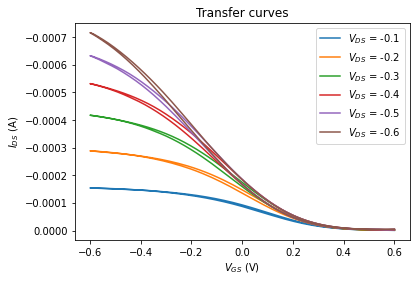

In [ ]:
###     Run TRANSFER curves     ###

# Settings
Vg_init = 0.6
Vg_final = -0.6
Vd_init = -0.1
Vd_final = -0.6             # Put same value for Vd_init and Vd_final for 1 measurement
Vd_step = -0.1              # don't use 0
time_per_point = 5e-2       # Minimum value of 2e-5
points_per_sweep = 100
reverse_sweep = True        
Ig_range = 1e-5            # Must be 1e-X format, minimum X = 0 maximum X = 7
Id_range = 1e-2            # Must be 1e-X format, minimum X = 0 maximum X = 7
t_hold_before_meas = 0.5     

# ------------------------------------------------------------------------------------------

# Generate array of gate voltage values based on user input
Vd_values = np.empty((round((Vd_final-Vd_init)/Vd_step)+1,))
for i in range(0,len(Vd_values)):
    if Vd_init > Vd_final:
        step = -1*abs(Vd_step)
    else:
        step = abs(Vd_step)
    Vd_values[i] = round(Vd_init + step*i,4)

# Generate sweep for gate voltage based on user input
vg_list = generateLinSweep(points_per_sweep,Vg_init,Vg_final,reverse=reverse_sweep)
vd_list = "{:.1E}".format(Vd_values[0])

# parameters format (list of strings, units of seconds, amps, volts):
# [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
#  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
#  (8) pre-measurement voltage hold time]

parameters = []
parameters.append("{:.0f}".format(len(vg_list.split(','))))
parameters.append("{:.1E}".format(time_per_point))
parameters.append("{:.1E}".format(time_per_point/2))
parameters.append("{:.1E}".format((time_per_point/2)*0.8))
parameters.append("{:.0E}".format(Ig_range))
parameters.append("{:.0E}".format(Id_range))
parameters.append("{:.0f}".format(len(vg_list.split(','))))
parameters.append("{:.0f}".format(len(vd_list.split(','))))
parameters.append(t_hold_before_meas)

# Create empty array to store output data
transfer = np.empty((len(Vd_values),int(parameters[0]),4))

# Run transfer curve for each drain voltage and plot results
# Run output curve for each gate voltage and plot results
transfer[0] = runListSweep(parameters,vg_list,vd_list,wait=False)
Vg = np.asarray([float(i) for i in vg_list.split(',')])
plt.plot(Vg,transfer[0,:,2],label="$V_{DS}$ = " + str(Vd_values[0]))

for i in range(1,len(transfer)):
    vd_list = "{:.1E}".format(Vd_values[i])
    transfer[i] = runListSweep(parameters,vg_list,vd_list)
    plt.plot(Vg,transfer[i,:,2],label="$V_{DS}$ = " + str(Vd_values[i]))

plt.gca().invert_yaxis()
plt.xlabel("$V_{GS}$ (V)")
plt.ylabel("$I_{DS}$ (A)")
plt.title("Transfer curves")
plt.legend()

# Specify the desired VD value for finding the midpoint
desired_VD = -0.6

# Find the index of the desired VD value in the Vd_values array
desired_VD_index = np.where(Vd_values == desired_VD)[0][0]

# Extract the transfer curve data for the desired VD value
transfer_data_desired_VD = transfer[desired_VD_index]

# Find the midpoint of the transfer curve
midpoint_index = np.argmax(np.abs(transfer_data_desired_VD[:, 2]))  # Find the index of the maximum absolute value of IDS
midpoint_VG = Vg[midpoint_index]  # Get the corresponding VG value

# Print the midpoint VG value
print("Midpoint VG for VD =", desired_VD, "is", midpoint_VG)

plt.axvline(midpoint_VG, color='r', linestyle='--', label='Midpoint VG')
plt.legend()



# Turn SMU output off after all measurements
inst.write(":outp1 off")
inst.write(":outp2 off")


In [148]:
###     Save last TRANSFER measurement     ###
# Select folder and filename where the data will be stored

# Make sure to change filename, otherwise it will overwrite previously saved meaurement
filename = "Transfer"

# Create the path before trying to save
path = ""  # write path for the folder you want to save data into

# I usually separate my data into folders for each device, adjust based on your preferred file organization
folder = "Device " + str(device) + "\\"

# ------------------------------------------------------------------------------------------

trans_data = pd.DataFrame()
trans_data["Time (s)"] = transfer[0,:,1]
trans_data["Vgs (V)"] = Vg
for i in range(0,len(transfer)):
    trans_data["Ids (A) at Vd = " + str(Vd_values[i]) + " V"] = transfer[i,:,2]
    trans_data["Igs (A) at Vd = " + str(Vd_values[i]) + " V"] = transfer[i,:,0]
# Saves the data as a csv file
trans_data.to_csv(path+folder+filename)

12

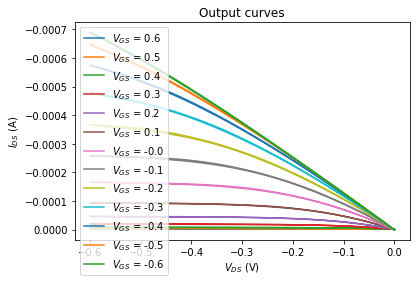

In [149]:
###     Run Output Curve     ###

# User settings (All values in units of V, A, and s)
Vg_init = 0.6
Vg_final = -0.6
Vg_step = -0.1
Vd_init = 0
Vd_final = -0.6
time_per_point = 5e-2          # Minimum value of 2e-5
points_per_sweep = 100         # Number of measurements 
reverse_sweep = True           # Reverse sweep for 
Ig_range = 1e-5                # Must be 1e-X format, minimum X = 0 maximum X = 7
Id_range = 1e-2                # Must be 1e-X format, minimum X = 0 maximum X = 7
t_hold_before_meas = 0.5       # Delay time between turning on SMU and measurement

# ------------------------------------------------------------------------------------------

# Generate array of gate voltage values based on user input
Vg_values = np.empty((round((Vg_final-Vg_init)/Vg_step)+1,))
for i in range(0,len(Vg_values)):
    if Vg_init > Vg_final:
        step = -1*abs(Vg_step)
    else:
        step = abs(Vg_step)
    Vg_values[i] = round(Vg_init + step*i,4)

# Generate sweep for drain voltage based on user input
vd_list = generateLinSweep(points_per_sweep,Vd_init,Vd_final,reverse=reverse_sweep)
vg_list = "{:.1E}".format(Vg_values[0])

# Create measurement parameters
# parameters format (list of strings, units of seconds, amps, volts):
# [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
#  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
#  (8) pre-measurement voltage hold time]

parameters = []
parameters.append("{:.0f}".format(len(vd_list.split(','))))   #0
parameters.append("{:.1E}".format(time_per_point))            #1
parameters.append("{:.1E}".format(time_per_point/2))          #2
parameters.append("{:.1E}".format((time_per_point/2)*0.8))    #3
parameters.append("{:.0E}".format(Ig_range))                  #4
parameters.append("{:.0E}".format(Id_range))                  #5
parameters.append("1")                                        #6
parameters.append("{:.0f}".format(len(vd_list.split(','))))   #7
parameters.append(t_hold_before_meas)                         #8

# Create empty array to store output data
output = np.empty((len(Vg_values),int(parameters[0]),4))

# Run output curve for each gate voltage and plot results
output[0] = runListSweep(parameters,vg_list,vd_list)
Vd = np.asarray([float(i) for i in vd_list.split(',')])
plt.plot(Vd,output[0,:,2],label="$V_{GS}$ = " + str(Vg_values[0]))

for i in range(1,len(output)):
    vg_list = "{:.1E}".format(Vg_values[i])
    output[i] = runListSweep(parameters,vg_list,vd_list)
    plt.plot(Vd,output[i,:,2],label="$V_{GS}$ = " + str(Vg_values[i]))

plt.gca().invert_yaxis()
plt.xlabel("$V_{DS}$ (V)")
plt.ylabel("$I_{DS}$ (A)")
plt.title("Output curves")
plt.legend()
    
# Turn instrument output off after measurement
inst.write(":outp1 off")
inst.write(":outp2 off")


In [150]:
###     Save last OUTPUT measurement     ###
# Select folder and filename where the data will be stored

# Make sure to change filename, otherwise it will overwrite previously saved meaurement

# Create the path before trying to save
#path = "C:\\Users\\skeen\\Dropbox\\000_Postdoctoral_Research\\Voltage-dependent mobility with Sophia\\OECT Data\\2023-02-01_PEDOTPSS_no_gops_ITO\\145 C\\"
folder = "Device " + str(device) +"\\"

# ------------------------------------------------------------------------------------------
filename = "Output"
outp_data = pd.DataFrame()
outp_data["Time (s)"] = output[0,:,1]
outp_data["Vds (V)"] = Vd
for i in range(0,len(output)):
    outp_data["Ids (A) at Vg = " + str(Vg_values[i]) + " V"] = output[i,:,2]
    outp_data["Igs (A) at Vg = " + str(Vg_values[i]) + " V"] = output[i,:,0]
# Saves last Output measurement as a csv file 
outp_data.to_csv(path+folder+filename)

In [504]:
###     AC Measurement Voltage Sweep    ###

# Save path
#path = "C:\\Users\\skeen\\Desktop\\MM460_4A_remeasure\\Device " + str(device) +"\\AC Sweep\\"

# Iterates threough a predefined set of gate voltages for voltage-dependent mobility measurment
gate_voltage_list =[-0.3,-0.2,-0.1,-0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
#gate_voltage_list = [-0.1,-0.6]
drain_voltage_list = [-0.1,-0.6]

min_freq = 1
max_freq = 4166
Id_range = 1e-1
points_per_decade = 10    
cycles = 10
Est_capacitance = 1e-6      # Give and estimate of the device capacitance. Best to overesimate
# The estimated capacitance determines the current sense range for the gate channel

max_meas_time = 1e-3        # For best signal to noise should be 1e-3 or lower, longer meas times cause noise
min_meas_time = 2e-5        # Minimum for the instrument is 2e-5

Vg_amplitude = 0.01         # Can increase if signal-to-noise is poor
t_hold_before_meas = 0.2    # time in s for the gate to stabilize

for k in range(0,len(drain_voltage_list)):
    for j in range(0,len(gate_voltage_list)):
    
        Vd = drain_voltage_list[k]
        Vg_offset = gate_voltage_list[j]
        
        Id_range = findIdRange(Vd,Vg_offset,Ig_range)
        
        # ------------------------------------------------------------------------------------------

        # Need to calculate frequency, points per cycle, and measurement time for each measurment
        freqs,points_per_cycle,meas_time = generateFreqsV2(min_freq,max_freq,points_per_decade,max_meas_time,min_meas_time)

        vg_list = generateSineSweep(cycles,points_per_cycle[0],Vg_amplitude,Vg_offset)
        vd_list = "{:.1E}".format(Vd)

        Ig_range = np.power(10,np.ceil(np.log10(Vg_amplitude*(2*np.pi*freqs[0]*Est_capacitance))))

        # parameters format (list of strings, units of seconds, amps, volts):
        # [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
        #  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
        #  (8) premeasurement voltage hold time]

        parameters = []
        parameters.append("{:.0f}".format(len(vg_list.split(','))))
        parameters.append("{:.1E}".format(meas_time[0]))
        parameters.append("{:.1E}".format(meas_time[0]/2))
        parameters.append("{:.1E}".format((meas_time[0]/2)*0.8))
        parameters.append("{:.0E}".format(Ig_range))
        parameters.append("{:.0E}".format(Id_range))
        parameters.append("{:.0f}".format(len(vg_list.split(','))))
        parameters.append("1")
        parameters.append(t_hold_before_meas)

        sweeps = []

        data = runListSweep(parameters,vg_list,vd_list)
        sweeps.append(data)

        for i in range(1,len(meas_time)):
            Ig_range = np.power(10,np.ceil(np.log10(Vg_amplitude*(2*np.pi*freqs[i]*Est_capacitance))))
            vg_list = generateSineSweep(cycles,points_per_cycle[i],Vg_amplitude,Vg_offset)
            if Ig_range > 1e-5:
                Ig_range = 1e-5
            parameters[0] = "{:.0f}".format(len(vg_list.split(',')))
            parameters[1] = "{:.1E}".format(meas_time[i])
            parameters[2] = "{:.1E}".format(float(meas_time[i])/2)
            parameters[3] = "{:.1E}".format((float(meas_time[i])/2)*0.8)
            parameters[4] = "{:.0E}".format(Ig_range)
            parameters[6] = "{:.0f}".format(len(vg_list.split(',')))

            data = runListSweep(parameters,vg_list,vd_list)
            sweeps.append(data)

        inst.write(":syst:beep 800,1.5")
        # Turn instrument output off after measurement
        inst.write(":outp1 off")
        inst.write(":outp2 off")
        
        ### Save data ###
        filename = "AC Sweep\\AC Sweep Vg " + str(Vg_offset) + " Vd " + str(Vd)
        with open(path+folder+filename,'wb') as fp:
            pickle.dump(sweeps,fp)

In [ ]:
###     Fit voltage AC sweep data series to get mobility(s)    ###

plot_C = True
plot_mu = True
# Will plot the linear fits used to extract mobity to check if they are fitting the linear region
plot_mu_fits = True
properties = {}
fits = {}
all_sweeps = {}

# Specify the folder 
folder = ""

# Specify the length of the channel in µm
length = 

# Make sure this Vg array matches the experiment being analzyed
Vg = np.asarray([-0.3,-0.2,-0.1,-0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
# Pick the from the ones tested Vd
Vd = -0.6  

# Initialize variables
gm = np.empty((len(Vg),len(freqs)))
C = np.empty((len(Vg),))
mu = np.empty((len(Vg),))
Ig_Id_fit = np.empty((len(Vg),len(freqs),8))
    
Vg_sweeps = []
V_dep = np.empty((3,len(Vg)))

# Perform and store fits
for i in range(0,len(Vg)):
    filename = "AC Sweep Vg " + str(Vg[i]) + " Vd " + str(Vd)

    with open(folder+filename,'rb') as fp:
            sweeps = pickle.load(fp)
    
    # Fit to sine(t,I0,freq,amp,phase)
    Ig_fit,Id_fit = fitSweeps(sweeps,freqs,points_per_cycle)
    Ig_Id_fit[i,:,:4] = Ig_fit
    Ig_Id_fit[i,:,4:] = Id_fit
    
    # Calculate gm
    gm[i] = np.divide(abs(Id_fit[:,2]),Vg_amplitude)
    # Fit capacitance
    
    Z = np.divide(Vg_amplitude,abs(Ig_fit[:,2]))
    b_fit = np.mean(np.log10(Z[:7])+np.log10(freqs[:7]))
    C[i] = np.divide(np.power(10,-1*b_fit),2*np.pi)

    # Fit mobility
    # can use a reduced freq range if some of the data is poor quality
    plt.figure(i)
    m, b = np.polyfit(1/freqs[:],abs(Id_fit[:,2]/Ig_fit[:,2]), 1)
    
    # Reported in cm^2 V^-1 s^-1
    mu[i] = abs(m*(length*1e-4)*(length*1e-4)*2*np.pi/Vd)
    
    if plot_mu_fits == True:
        plt.plot(1/freqs[:],abs(Id_fit[:,2]/Ig_fit[:,2]),'o')
        plt.plot(1/freqs[:],1/freqs[:]*m+b)

if plot_mu == True:
    plt.plot(Vg,mu,'o')
if plot_C == True:
    plt.plot(Vg,C,'o')

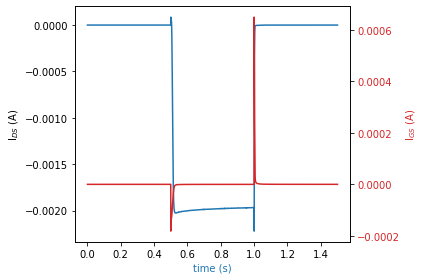

In [34]:
###     Rise time measurement     ###

Vd = -0.1
Vg_init = 0.4
Vg_final = -0.6
Id_range = 1e-2
Ig_range = 1e-3
pulse_width = 5e-1          # time in seconds
t_hold_before_meas = 0.5

# ---------------------------------------------------------------------------------------------------

meas_time = 2e-4            # Max sweep steps of 2500

vg_list = generatePulse(Vg_init,Vg_final,pulse_width,meas_time)
vd_list = "{:.1E}".format(Vd)

# parameters format (list of strings, units of seconds, amps, volts):
# [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
#  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
#  (8) premeasurement voltage hold time]

parameters = []
parameters.append("{:.0f}".format(len(vg_list.split(','))))
parameters.append("{:.1E}".format(meas_time))
parameters.append("{:.1E}".format(meas_time/2))
parameters.append("{:.1E}".format((meas_time/2)*0.8))
parameters.append("{:.0E}".format(Ig_range))
parameters.append("{:.0E}".format(Id_range))
parameters.append("{:.0f}".format(len(vg_list.split(','))))
parameters.append("1")
parameters.append(t_hold_before_meas)

pulse = runListSweep(parameters,vg_list,vd_list)

inst.write(':outp1 off')
inst.write(':outp2 off')

plotPulse(pulse)


In [77]:
###     Save last RISE TIME measurement     ###
# Select folder and filename where the data will be stored

# Make sure to change filename, otherwise it will overwrite previously saved meaurement
filename = "Rise time Vg " + str(Vg_init) + " to " + str(Vg_final) + " Vd " + str(Vd)

# Create the path before trying to save
path = "C:\\Users\\skeen\\Desktop\\2022-02-16_MM460_4A\\Device " + str(device) +"\\"
folder = ""

# ------------------------------------------------------------------------------------------

outp_data = pd.DataFrame()
outp_data["Time (s)"] = pulse[:,1]
outp_data["Vds (V)"] = Vd
outp_data["Ids (A)"] = pulse[:,2]
outp_data["Igs (A)"] = pulse[:,0]
    
outp_data.to_csv(path+folder+filename)

In [ ]:
# ------------------------------------------------------------------------------------------------------------
###     Rise time measurement series     ###

# Create the path before trying to save
#path = "C:\\Users\\skeen\\Dropbox\\000_Postdoctoral_Research\\Voltage-dependent mobility with Sophia\\OECT Data\\2022-11-18_pg2t-tt_2A_annealed\\"
#folder = "Device 1\\"

Vd = [0.1,0.6]
Vg_init = [-0.2,-0.1,0.0,0.1,0.2,0.3]
for i in range(0,len(Vd)):
    for j in range(0,len(Vg_init)):
        Vg_final = 0.4
        Id_range = 1e-6
        Ig_range = 1e-5
        pulse_width = 5e-1          # time in seconds
        t_hold_before_meas = 0.5

        # ---------------------------------------------------------------------------------------------------

        meas_time = 2e-4            # Max sweep steps of 2500

        vg_list = generatePulse(Vg_init[j],Vg_final,pulse_width,meas_time)
        vd_list = "{:.1E}".format(Vd[i])

        # parameters format (list of strings, units of seconds, amps, volts):
        # [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
        #  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
        #  (8) premeasurement voltage hold time]

        parameters = []
        parameters.append("{:.0f}".format(len(vg_list.split(','))))
        parameters.append("{:.1E}".format(meas_time))
        parameters.append("{:.1E}".format(meas_time/2))
        parameters.append("{:.1E}".format((meas_time/2)*0.8))
        parameters.append("{:.0E}".format(Ig_range))
        parameters.append("{:.0E}".format(Id_range))
        parameters.append("{:.0f}".format(len(vg_list.split(','))))
        parameters.append("1")
        parameters.append(t_hold_before_meas)

        pulse = runListSweep(parameters,vg_list,vd_list)
        
        #plotPulse(pulse)
        
        ###     Save last RISE TIME measurement     ###
        # Select folder and filename where the data will be stored

        # Make sure to change filename, otherwise it will overwrite previously saved meaurement
        filename = "Rise time Vg " + str(Vg_init[j]) + " to " + str(Vg_final) + " Vd " + str(Vd[i])

        # Create the path before trying to save
        #path = "C:\\Users\\skeen\\Desktop\\2022-02-17_MM461_1B\\"
        #folder = "Device " + str(device) + " "

        # ------------------------------------------------------------------------------------------

        outp_data = pd.DataFrame()
        outp_data["Time (s)"] = pulse[:,1]
        outp_data["Vds (V)"] = Vd[i]
        outp_data["Ids (A)"] = pulse[:,2]
        outp_data["Igs (A)"] = pulse[:,0]

        outp_data.to_csv(path+folder+"Rise time\\"+filename)

inst.write(':outp1 off')
inst.write(':outp2 off')

In [119]:
###     Drain voltage rise time measurement series     ###

Vd_final = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6]
Vg = [0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0,-0.1,-0.2,-0.3,-0.4,-0.5]
for i in range(0,len(Vg)):
    for j in range(0,len(Vd_final)):
        Vd_init = 0
        Id_range = 1e-2
        Ig_range = 1e-3
        pulse_width = 1e-1          # time in seconds
        t_hold_before_meas = 0.5

        # ---------------------------------------------------------------------------------------------------

        meas_time = 4e-5            # Max sweep steps of 2500

        vd_list = generatePulse(Vd_init,Vd_final[j],pulse_width,meas_time)
        vg_list = "{:.1E}".format(Vg[i])

        # parameters format (list of strings, units of seconds, amps, volts):
        # [(0) measurment points,(1) time per point,(2) measurement delay,(3) aquisition time,
        #  (4) gate current range,(5) drain current range,(6) gate points,(7) drain points,
        #  (8) premeasurement voltage hold time]

        parameters = []
        parameters.append("{:.0f}".format(len(vd_list.split(','))))
        parameters.append("{:.1E}".format(meas_time))
        parameters.append("{:.1E}".format(meas_time/2))
        parameters.append("{:.1E}".format((meas_time/2)*0.8))
        parameters.append("{:.0E}".format(Ig_range))
        parameters.append("{:.0E}".format(Id_range))
        parameters.append("{:.0f}".format(len(vg_list.split(','))))
        parameters.append("{:.0f}".format(len(vd_list.split(','))))
        parameters.append(t_hold_before_meas)

        pulse = runListSweep(parameters,vg_list,vd_list)
        
        #plotPulse(pulse)
        
        ###     Save last RISE TIME measurement     ###
        # Select folder and filename where the data will be stored

        # Make sure to change filename, otherwise it will overwrite previously saved meaurement
        filename = "Drain rise time Vg " + str(Vg[i]) + " Vd " + str(Vd_init) + " to " + str(Vd_final[j])

        # Create the path before trying to save
        #path = "C:\\Users\\skeen\\Desktop\\2022-02-17_MM461_1B\\"
        folder = "Device " + str(device) + "\\"

        # ------------------------------------------------------------------------------------------

        outp_data = pd.DataFrame()
        outp_data["Time (s)"] = pulse[:,1]
        outp_data["Ids (A)"] = pulse[:,2]
        outp_data["Igs (A)"] = pulse[:,0]

        outp_data.to_csv(path+folder+filename)

inst.write(':outp1 off')
inst.write(':outp2 off')

12